# Project 1 What Made You Happy Today?
### _Author: Fei Zheng_

## 0. Preparation

A general descriptions for the libraries from official documents:  
+ `sys`: This module provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter.
+ `warnings`: Warning messages are typically issued in situations where it is useful to alert the user of some condition in a program, where that condition (normally) doesn’t warrant raising an exception and terminating the program.
+ `re`: This module provides regular expression matching operations similar to those found in Perl.
+ `random`: This module implements pseudo-random number generators for various distributions.
+ `pandas`: Pandas provides high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
+ `numpy`: NumPy is the fundamental package for scientific computing in Python.
+ `matplotlib`: Matplotlib is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.
+ `nltk`: NLTK is a leading platform for building Python programs to work with human language data.  
  
There are some other libraries and functions I will use later. Following the general rule, I will import them when necessary, where the description will be attached also.

In [1]:
# load libraries and functions
from __future__ import print_function
import sys
import warnings
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import plotly.offline as py
import plotly.graph_objs as go

In [2]:
# ignore some warnings
py.init_notebook_mode(connected=True)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

In [3]:
# print the python version
print(sys.version)

3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


## 1. Load the data

In [4]:
# read the data from subfolder `data` in the project
hm_data = pd.read_csv('../data/HappyDB/happydb/data/cleaned_hm.csv')

First, let's geta general sense of the data!  
For convenience, here is a variables' descriotion copied from official github documents.  
+ __hmid (int)__: Happy moment ID
+ __wid (int)__: Worker ID
+ __reflection_period (str)__: Reflection period used in the instructions provided to the worker (3m or 24h)
+ __original_hm (str)__: Original happy moment
+ __cleaned_hm (str)__: Cleaned happy moment
+ __modified (bool)__: If True, original_hm is "cleaned up" to generate cleaned_hm (True or False)
+ __predicted_category (str)__: Happiness category label predicted by our classifier (7 categories. Please see the reference for details)
+ __ground_truth_category (str)__: Ground truth category label. The value is NaN if the ground truth label is missing for the happy moment
+ __num_sentence (int)__: Number of sentences in the happy moment

In [5]:
hm_data.head(10)

hmid   wid reflection_period  \
0  27673  2053               24h   
1  27674     2               24h   
2  27675  1936               24h   
3  27676   206               24h   
4  27677  6227               24h   
5  27678    45               24h   
6  27679   195               24h   
7  27680   740               24h   
8  27681     3               24h   
9  27682  4833               24h   

                                         original_hm  \
0  I went on a successful date with someone I fel...   
1  I was happy when my son got 90% marks in his e...   
2       I went to the gym this morning and did yoga.   
3  We had a serious talk with some friends of our...   
4  I went with grandchildren to butterfly display...   
5                            I meditated last night.   
6  I made a new recipe for peasant bread, and it ...   
7  I got gift from my elder brother which was rea...   
8            YESTERDAY MY MOMS BIRTHDAY SO I ENJOYED   
9  Watching cupcake wars with my three teen children   

                                          cleaned_hm  modified  num_sentence  \
0  I went on a successful date with someone I fel...      True             1   
1  I was happy when my son got 90% marks in his e...      True             1   
2       I went to the gym this morning and did yoga.      True             1   
3  We had a serious talk with some friends of our...      True             2   
4  I went with grandchildren to butterfly display...      True             1   
5                            I meditated last night.      True             1   
6  I made a new recipe for peasant bread, and it ...      True             1   
7  I got gift from my elder brother which was rea...      True             1   
8            YESTERDAY MY MOMS BIRTHDAY SO I ENJOYED      True             1   
9  Watching cupcake wars with my three teen children      True             1   

  ground_truth_category predicted_category  
0                   NaN          affection  
1                   NaN          affection  
2                   NaN           exercise  
3               bonding            bonding  
4                   NaN          affection  
5               leisure            leisure  
6                   NaN        achievement  
7                   NaN          affection  
8                   NaN   enjoy_the_moment  
9                   NaN          affection

Obviously, `cleaned_hm` must be my main focus.  
There are so many missing values in `ground_truth_category` that makes it difficult to deal with.  
Luckily, we have `predicted_category` which has 7 categories. This might provide some useful information!  
And also, official database provides some affiliated `.csv` documents(e.g., `senselabel.csv`, `pets-dict.csv`) which might be useful later.   

## 2. Text Preprocessing

Whatever, let's first process `cleaned_hm`.  
Generally, there are several standard steps for text preprocessing. I summarize below:    
1. Transform sentences into words, which is also called `tokenization`.  
2. Tag the part of speech, which is called `POS Tagging`(Optional).   
3. Remove the punctuation and non-alpha words(e.g. numbers, whitespace).  
4. Correct the spelling mistakes.  
5. Transform all words into lowercase. 
6. `Lemmatization/Stemming`.  
7. Remove too short words and stopwords.

#### Step1. Tokenization

In [6]:
hm = hm_data['cleaned_hm'].copy()
token_hm = [nltk.word_tokenize(sent) for sent in hm]

#### Step2. POS tagging

In [7]:
pos_hm = (nltk.pos_tag(sent) for sent in token_hm)

#### Step3. Remove the punctuation and non-alpha words

`string.punctuation`: This is a string of ASCII characters which are considered punctuation characters in the C locale.  
!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~

In [8]:
from string import punctuation
punct_hm = [[tup for tup in sent if re.search(r'\D+', tup[0]) and tup[0] not in list(punctuation) 
            and tup[0] not in ["'s","'d","'ll",'',"'m","'ve"]]
             for sent in pos_hm]

#### Step4. Check the spelling mistakes

`pyenchant`: This package provides a set of Python language bindings for the Enchant spellchecking library.[@rfk/pyenchant](https://github.com/rfk/pyenchant)

In [9]:
import enchant
d = enchant.Dict('en_US') # US English
check_hm = [[d.check(tup[0]) for tup in sent] for sent in punct_hm]
num_mis = len([word for sent in check_hm for word in sent if word == False])
print('There are {0} spelling mistakes. The mistake rate is {1:.2f}%'.format(num_mis,
    100 * num_mis/len([word for sent in check_hm for word in sent])))

There are 34889 spelling mistakes. The mistake rate is 1.90%


Let's have a look at what kind of the spelling mistakes they are.

In [10]:
# get all the indexes for the spelling mistake(False)
indexes = [[i,j] for i in range(len(check_hm)) for j,x in enumerate(check_hm[i]) if x == False]

# randomly choose 10 some spelling mistakes
random.seed(1)
for i in range(10):
    choice = random.choice(range(len(indexes)))
    idx1 = indexes[choice][0]
    idx2 = indexes[choice][1]
    print('The mistake word is: {0}.\nThe sentence is: {1} \n'.format(punct_hm[idx1][idx2][0], hm[idx1]))

The mistake word is: glitched.
The sentence is: I got a free pack of cigarettes because the computer glitched out when I went to pay. 

The mistake word is: n't.
The sentence is: My knee didn't hurt all day. 

The mistake word is: Overwatch.
The sentence is: I managed to properly figure out how a recent update to Overwatch would impact the DPS of various characters, and how that might affect balance. 

The mistake word is: cryptocurrency.
The sentence is: The coin on a cryptocurrency exchange that I was hoping would drop in price so I could buy it, droppedd a lot in price and I was able to buy a lot of it for cheap. 

The mistake word is: harvard.
The sentence is: My kids will be able to see thier farther go to harvard 

The mistake word is: Veenhoven.
The sentence is: happiness in terms of living a good life, or flourishing, rather than simply as an emotion. Happiness in this sense was used to translate the Greek eudaimonia, and is still used in virtue ethics. There has been a transit

From the random examples above, some mistakes come from abbreviation(e.g. **don't** will be tokenized into **do** and **n't**) which is very meaningful and can be partly dealt with by **POS tagging** in **nltk**. Some other mistakes come from special words(e.g **harvard**, **facebook**).  
  
It's tough to deal with such spelling problems. Considering the low misspelling rate, we could just ignore them.  

#### Step5. Transform to lowercase

In [11]:
lower_hm = [[(tup[0].lower(), tup[1]) for tup in sent] for sent in punct_hm]

#### Step6. Lemmatization

In [12]:
# def the function that convert the POS from original form to consistent form
from nltk.corpus import wordnet
def get_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [13]:
wnl = nltk.WordNetLemmatizer()
lemma_hm = [[(wnl.lemmatize(tup[0], get_pos(tup[1])), tup[1]) for tup in sent] for sent in lower_hm]

#### Step6. Remove too short words and stopwords

In [14]:
# remove words whose length < 3 and remove stopwords
from nltk.corpus import stopwords
words = stopwords.words('english') + ["happy","ago","yesterday","lot","today","month","last","week","past",
                                     "get","make","day","n't","take","year","time","really","one"]
stop_hm = [[tup for tup in sent 
            if len(tup[0]) >= 3 and tup[0] not in words and not re.search(r"^\'[a-zA-Z]", tup[0])] 
           for sent in lemma_hm]

#### Step7. Combine the processed text to the original data and export

In [15]:
hm_data['preprocess_hm'] = [' '.join([tup[0] for tup in sent]) for sent in stop_hm]
hm_data['preprocess_ori_hm'] = [' '.join([tup[0] for tup in sent]) for sent in lower_hm]
hm_data.to_csv('../output/preprocess_hm.csv', index=False)

## 3. Exploratory Data Analysis

In [46]:
# combine the processed data with demographic data
hm_data = pd.read_csv('../output/preprocess_hm.csv')
demo_data = pd.read_csv('../data/HappyDB/happydb/data/demographic.csv')
hm_data = hm_data.merge(demo_data, on = 'wid', how = 'inner', copy=False)

In [47]:
# select rows that satisfies specific row conditions and export
# transform Age to integer and count the words
def trans_age(age):
    try:
        return int(float(age))
    except:
        return np.nan
def word_count(words):
    try:
        return len(words.strip().split(' '))
    except:
        return np.nan

hm_data = hm_data.assign(age = hm_data['age'].map(trans_age),
                        word_count = hm_data['preprocess_hm'].map(word_count))

# filter the rows
hm_data_sub = hm_data.loc[(hm_data['gender'].isin(['m','f'])) &
                     (hm_data['marital'].isin(['single','married','divorced'])) &
                     (hm_data['parenthood'].isin(['n','y'])) &
                     (hm_data['reflection_period'].isin(['3m','24h']))&
                     (hm_data['age'].between(1,100)) &
                     (~hm_data['preprocess_hm'].isnull()) &
                     (hm_data['word_count'] > 1)
                         ,['wid','original_hm','cleaned_hm','predicted_category',
                          'preprocess_hm','age','country','gender','marital','parenthood','word_count','preprocess_ori_hm']]
# export
hm_data_sub.to_csv('../output/clean_hm.csv', index = False)

### 3.1 What's the most frequent words in general?

In [4]:
from wordcloud import WordCloud, STOPWORDS
hm_data = pd.read_csv('../output/clean_hm.csv')

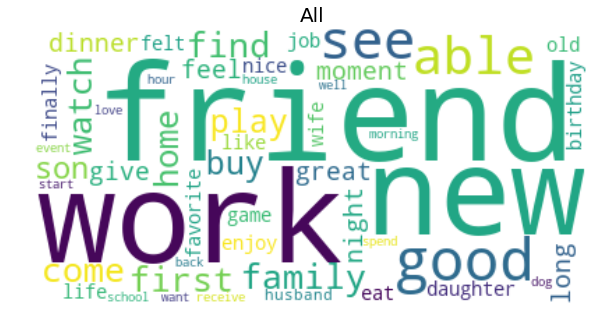

In [5]:
wordcloud = WordCloud(stopwords=STOPWORDS, max_words=50, background_color="white")
wordcloud1 = wordcloud.generate_from_frequencies(pd.Series([word for sent in hm_data['preprocess_hm'] 
                                                            for word in sent.strip().split(' ') ]).value_counts())
wordcloud1.to_file('../figs/wordcloud_all.png')

fig = plt.figure(figsize = (10,8))
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis('off')
plt.title('All', fontsize = 20)

plt.show()

For most people, __friends__, __work__ or get something __new__ are the most important source of happiness.

### 3.2 What are the differences for different people?

Because `friend`, `work`, `new`, `good`, `see` appear so frequently, I will discard them in some places.

In [6]:
wordcloud = WordCloud(stopwords=STOPWORDS, max_words=50, background_color="white")
wordlist = ['friend', 'work', 'new', 'good', 'see']
def wordcloud_gen(characteristic, name, filename, discard=True):
    if discard:
        x = wordcloud.generate_from_frequencies(dict(pd.Series(
        [words for sent in hm_data.loc[hm_data[str(characteristic)] == str(name), 'preprocess_hm'] 
         for words in sent.strip().split(' ') if words not in wordlist]).value_counts()))
    else:
        x = wordcloud.generate_from_frequencies(dict(pd.Series(
        [words for sent in hm_data.loc[hm_data[str(characteristic)] == str(name), 'preprocess_hm'] 
         for words in sent.strip().split(' ')]).value_counts()))
    x.to_file(filename)
    return x

#### 3.2.1 Is there any differenc between males and females?

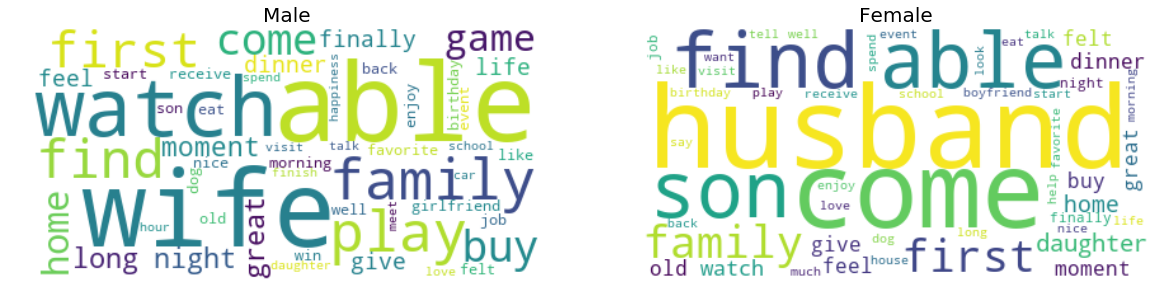

In [7]:
# wordcloud for gender
fig,axes = plt.subplots(1,2,figsize=(20,16))

ax = axes[0]
ax.imshow(wordcloud_gen('gender','m', '../figs/wordcloud_male.png'), interpolation="bilinear")
ax.axis('off')
ax.set_title("Male", fontsize=20)

ax = axes[1]
ax.imshow(wordcloud_gen('gender','f','../figs/wordcloud_female.png'), interpolation="bilinear")
ax.axis('off')
ax.set_title("Female", fontsize=20)

plt.show()

For both males and females, the __spouse__ is the most important part of happiness. For females, __child__ appear more frequently.

In [13]:
# percentage for different categories
category = hm_data['predicted_category'].value_counts().index.sort_values()
data0 = [
    go.Bar(
        x = category,
        y = hm_data.loc[hm_data['gender'] == 'm',['predicted_category']]
        .groupby('predicted_category').size().sort_index() / hm_data.groupby('predicted_category').size().sort_index(),
        name='Male'
    ),
    go.Bar(
        x = category,
        y = hm_data.loc[hm_data['gender'] == 'f',['predicted_category']]
        .groupby('predicted_category').size().sort_index() / hm_data.groupby('predicted_category').size().sort_index(),
        name='Female'
    )
]


layout = go.Layout(
    barmode='stack',
    title='Gender over predicted categories',
    xaxis=dict(
        title = 'Predicted Categories'
    ),
    yaxis=dict(
        title = 'Percentage'
    )
)

fig = go.Figure(data= data0,layout=layout)
py.iplot(fig, filename='Gender over predicted categorie')

From the plot, __exercise__ and __leisure__ could give the male more happiness, whereas __affection__ could give the female more happiness.  


#### 3.2.2 Is there any difference between those married and singles?

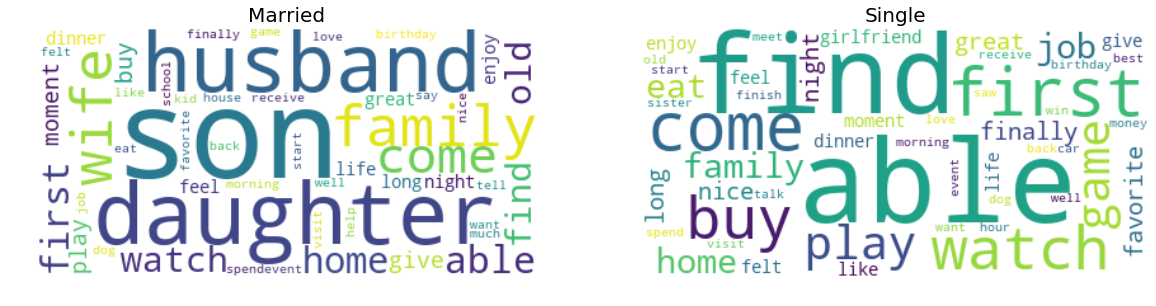

In [9]:
fig,axes = plt.subplots(1,2,figsize=(20,16))

ax = axes[0]
ax.imshow(wordcloud_gen('marital','married','../figs/wordcloud_married.png'), interpolation="bilinear")
ax.axis('off')
ax.set_title("Married", fontsize=20)

ax = axes[1]
ax.imshow(wordcloud_gen('marital','single','../figs/wordcloud_single.png'), interpolation="bilinear")
ax.axis('off')
ax.set_title("Single", fontsize=20)

plt.show()

The differences are obvious. __Families__ are the most part of those married. And it seems that the singles are always __finding__ something and they might have more time to experience some '__first__' things.

In [10]:
# percentage for different categories
data1 = [
    go.Bar(
        x = category,
        y = hm_data.loc[hm_data['marital'] == 'married',['predicted_category']]
        .groupby('predicted_category').size().sort_index() / hm_data.groupby('predicted_category').size().sort_index(),
        name='Married'
    ),
    go.Bar(
        x = category,
        y = hm_data.loc[hm_data['marital'] == 'single',['predicted_category']]
        .groupby('predicted_category').size().sort_index() / hm_data.groupby('predicted_category').size().sort_index(),
        name='Single'
    )
]


layout = go.Layout(
    barmode='stack',
    title='Marital status over predicted categories',
    xaxis=dict(
        title = 'Predicted Categories'
    ),
    yaxis=dict(
        title = 'Percentage'
    )
)

fig = go.Figure(data= data1,layout=layout)
py.iplot(fig, filename='Gender over predicted categorie')

Obviously, __affection__ gives more happiness to those married, whereas __exercise__ gives more to the single.  


#### 3.2.3 Is there any difference among difference ages?

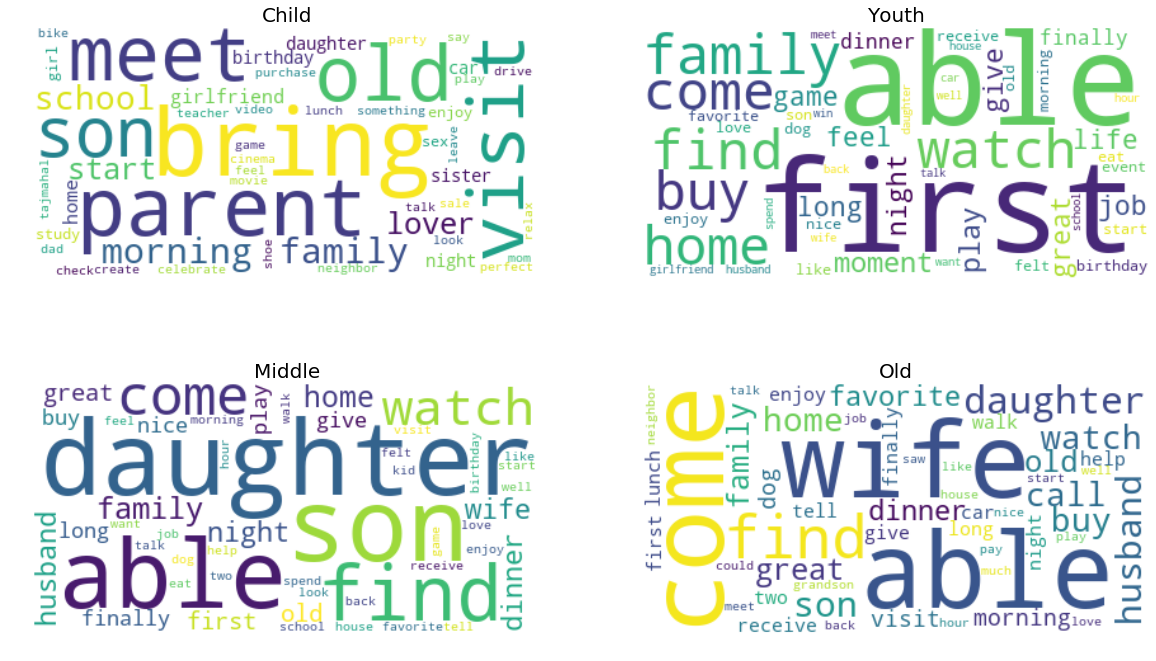

In [11]:
hm_data['Age'] = pd.cut(hm_data['age'], bins=[-1,14,35,60,100], labels=['Child','Youth','Middle','Old'])

fig,axes = plt.subplots(2,2,figsize=(20,12))

ax = axes[0,0]
ax.imshow(wordcloud_gen('Age','Child', '../figs/wordcloud_child.png'), interpolation="bilinear")
ax.axis('off')
ax.set_title("Child", fontsize=20)

ax = axes[0,1]
ax.imshow(wordcloud_gen('Age','Youth', '../figs/wordcloud_youth.png'), interpolation="bilinear")
ax.axis('off')
ax.set_title("Youth", fontsize=20)

ax = axes[1,0]
ax.imshow(wordcloud_gen('Age','Middle', '../figs/wordcloud_middle.png'), interpolation="bilinear")
ax.axis('off')
ax.set_title("Middle", fontsize=20)

ax = axes[1,1]
ax.imshow(wordcloud_gen('Age','Old', '../figs/wordcloud_old.png'), interpolation="bilinear")
ax.axis('off')
ax.set_title('Old', fontsize=20)

plt.show()

For child, it seems that __parent bring__ something __new__ will make them happy. For youth and the middle aged, __friend__ and __work__ are the important parts of happiness.  
  
And now let's have a look at `age` distribution among `predicted_categories`.

In [14]:
# age distribution for different categories
data2 = [go.Box(
    y = hm_data.loc[hm_data['predicted_category'] == category[i], 'age'],
    name = category[i]
) for i in range(len(category))]


layout = go.Layout(
    title='Age versus predicted categories',
    xaxis=dict(
        title = 'Predicted Category'
    ),
    yaxis=dict(
        title = 'Age'
    )
)

fig = go.Figure(data=data2,layout=layout)
py.iplot(fig, filename='Age versus predicted categories')

Not that different among different categories except that the ages of those who like __nature__ are larger and more spread distributed.  


## 4.  Model

In [17]:
# input the data
hm_data = pd.read_csv('../output/clean_hm.csv')
hm = hm_data['preprocess_hm']
hm = [x for x in hm]

### 4.1 Non-negative Matrix Factorization

Non-negative matrix factorization (NMF or NNMF), also non-negative matrix approximation[1][2] is a group of algorithms in multivariate analysis and linear algebra where a matrix V is factorized into (usually) two matrices W and H, with the property that all three matrices have no negative elements. This non-negativity makes the resulting matrices easier to inspect. Also, in applications such as processing of audio spectrograms or muscular activity, non-negativity is inherent to the data being considered. Since the problem is not exactly solvable in general, it is commonly approximated numerically.[wiki-NMF](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

num_features = 2000
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=num_features, stop_words='english')
hm_tfidf = tfidf_vectorizer.fit_transform(hm)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
# set the number of topics to 11
num_topics = 11

nmf = NMF(n_components=num_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(hm_tfidf)
W = nmf.fit_transform(hm_tfidf) # doc_topic
H = nmf.components_ # topic_word
# get the topic for each doc
hm_keys = []
for i in range(W.shape[0]):
    hm_keys.append(W[i].argmax())

In [19]:
# display topics
def display_topics(topic_word, feature_names, num_top_words):
    for topic_idx, topic in enumerate(topic_word):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))
num_top_words = 10
display_topics(H, tfidf_feature_names, num_top_words)

Topic 0:
friend old best meet talk long hang party lunch school
Topic 1:
new buy car purchase phone house shoe laptop bike computer
Topic 2:
work finish project early raise receive promotion complete able bonus
Topic 3:
dinner eat wife favorite delicious night restaurant cook nice husband
Topic 4:
play game video win team baseball basketball fun online son
Topic 5:
watch movie favorite episode enjoy night funny netflix season television
Topic 6:
home come dog able son long visit daughter walk morning
Topic 7:
good night feel sleep felt workout food book lunch grade
Topic 8:
birthday party celebrate gift surprise daughter present brother mother mom
Topic 9:
job interview offer receive pay want new promotion raise start
Topic 10:
family spend member enjoy vacation trip easter visit weekend celebrate


From the top 10 words of each topics, we can just get some clues about the 11 topics:
+ topic0: about the old friend
+ topic1: buy something new(car, phone)
+ topic2: finish work or projects
+ topic3: eat food with families
+ topic4: play games or win a game
+ topic5: watch movies or TVs
+ topic6: about the pet
+ topic7: confused topic, keyword is good, maybe just about something good
+ topic8: about birthday
+ topic9: about the job
+ topic10: spend time with family

But how about the relationships among different topics? Visualization!

### 4.2 Visualizatin (t-SNE)

T-distributed Stochastic Neighbor Embedding (t-SNE) is a machine learning algorithm for visualization developed by Laurens van der Maaten and Geoffrey Hinton. It is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability. [wiki-tSNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)

In [20]:
# filter part of the points
threshold = 0.04
idx = np.amax(W, axis=1) > threshold  # idx of doc that above the threshold
W1 = W[idx]
hm_keys1 = [x for i,x in enumerate(hm_keys) if idx[i] == True]

In [21]:
# t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, verbose=0, random_state=0, angle=0.8, init='pca')
hm_tsne = tsne.fit_transform(W1)

In [22]:
# prepare the colors and texts
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
])

text = ['Topic:'+str(i)+'. Content: '+ x for i,x in zip(hm_keys1,hm_data.loc[idx, 'cleaned_hm'])]

In [23]:
trace = go.Scatter3d(
    x = hm_tsne[:,0],
    y = hm_tsne[:,1],
    z = hm_tsne[:,2],
    text = text,
    hoverinfo = 'text',
    mode = 'markers',
    marker=dict(
        size=2,
        color=colormap[hm_keys1],
        colorscale='Viridis',
        opacity=0.8
    ),
    showlegend=False
)
layout = go.Layout(
    height=600,
    width=800,
    margin = dict(t=30,b=10,l=0,r=0),
    title='NMF Visualization in 3D'
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='NMF_Vis')

From the 3D plot, we can detect some interesting patterns:
+ The longer the sentences are, the more possible they are spread distributed.
+ If the sentence included some special words, it is prone to be far away from the group's main part.(__Varkala__ in brown)
+ There are some little clusters(__light green, brown, light blue, purple, blue, light red__), those sentences in the same cluster are very similar in __key words__ and __sentence structure__.
    + For light green points, we can find the cluster is mostly about __TV show__ and the lengths of sentences are all not long, whereas other light green points are mostly about __movies__. But all the light green points are all about __watch__ or __see__.
    + For purple points in cluster, they all include key words __good, friend, birthday, party__ and the the sentences are almost the same!
    + This is all happened in other point clusters.
+ There are some points away from the cluster which can express the same meaning(__light blue__) as the cluster. But they are regarded as different meanings. This is because we do all the things in the concept of words, ignoring the order of the words in the sentences. This is also the drawbacks of __Bag of Words__ model. If time permits, I would try __n_gram__ or __word embedding__, which might solve the problem.

In [24]:
# let's display the topics again
display_topics(H, tfidf_feature_names, 10)

Topic 0:
friend old best meet talk long hang party lunch school
Topic 1:
new buy car purchase phone house shoe laptop bike computer
Topic 2:
work finish project early raise receive promotion complete able bonus
Topic 3:
dinner eat wife favorite delicious night restaurant cook nice husband
Topic 4:
play game video win team baseball basketball fun online son
Topic 5:
watch movie favorite episode enjoy night funny netflix season television
Topic 6:
home come dog able son long visit daughter walk morning
Topic 7:
good night feel sleep felt workout food book lunch grade
Topic 8:
birthday party celebrate gift surprise daughter present brother mother mom
Topic 9:
job interview offer receive pay want new promotion raise start
Topic 10:
family spend member enjoy vacation trip easter visit weekend celebrate


### 4.3 Demographic Characteristics

In [25]:
hm_data = pd.read_csv('../output/clean_hm.csv')
hm_data['key'] = hm_keys

+ topic0: about the old friend
+ topic1: buy something new(car, phone)
+ topic2: finish work or projects
+ topic3: eat food with families
+ topic4: play games or win a game
+ topic5: watch movies or TVs
+ topic6: about the pet
+ topic7: confused topic, keyword is good, maybe just about something good
+ topic8: about birthday
+ topic9: about the job
+ topic10: spend time with family

In [26]:
# gender for different topics
topics = ['Friend Old', 'New Buy', 'Work Finish', 'Dinner Eat', 
          'Play Game', 'Watch Movie', 'Home Come', 'Good Night','Birthday Party','Job Interview','Famili Spend']
y = (hm_data.loc[hm_data['gender'] == 'm',['key']].groupby('key').size() / 
     hm_data.groupby('key').size()).sort_values(ascending=False)
x = np.array(topics)[y.index]
index = hm_data.loc[hm_data['gender'] == 'm',['key']].groupby('key').size().sort_index() / hm_data.groupby('key').size().sort_index()
data4 = [
    go.Bar(
        x = x,
        y = y,
        name='Male'
    ),
    go.Bar(
        x = x,
        y = 1-y,
        name='Female'
    )
]


layout = go.Layout(
    barmode='stack',
    title='Gender percentage for categories',
    xaxis=dict(
        title = 'Topics'
    ),
    yaxis=dict(
        title = 'Percentage'
    )
)

fig = go.Figure(data= data4,layout=layout)
py.iplot(fig, filename='Gender percentage for categories')

There are no very obvious differences between genders among topics. But we can detect that more males gain happiness from playing games or winning competition. It makes sense, right?